In [2]:
import snowflake.connector
import pandas as pd
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.metrics import roc_auc_score, recall_score, precision_score


In [4]:
def create_snowflake_connection():
    return snowflake.connector.connect(
    user= 'general_access',
    password= 'Xylo-data-bi-844tag',
    account= 'hba10191.us-east-1',
    warehouse= 'COMPUTE_WH',
    database='PROD_DB',
    schema='ADHOC',
    role= 'BI_ROLE'
    )

def get_data(conn, query):
    return pd.read_sql(query, conn)

conn = create_snowflake_connection()

# Query

In [5]:
query = """
with data1 as (
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2023-06-01' and date(a.CREATED_AT) < '2024-11-01'
and status = 'returned'

UNION

select a.ID, a.TRANSACTION_ID, a.USER_ID, a.BUSINESS_ID, a.EXTERNAL_ACCOUNT_ID, a.AMOUNT, a.CREATED_AT, a.UPDATED_AT, a.STATUS, 1 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS_EVENTS" b on a.id=b.PULL_FUNDS_REQUEST_ID
where b.event='rejected'
and b.description NOT LIKE ('%Automatically%')
and b.description NOT LIKE ('%External account not linked%')
and b.description NOT LIKE ('%External account in Error Status%')
and b.description NOT LIKE ('%Funds no longer available%')
and b.description NOT LIKE ('%External account name mismatch%')
and b.description NOT LIKE ('%Transfer was rejected because account is frozen%')
//and description LIKE ('%Doubtful Collectibility- Previously Returned Items%')
and a.CREATED_AT >='2023-06-01' and a.CREATED_AT <'2024-11-01'

UNION
  
select ID, TRANSACTION_ID, USER_ID, BUSINESS_ID, EXTERNAL_ACCOUNT_ID, AMOUNT, CREATED_AT, UPDATED_AT, STATUS, 0 as target
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.CREATED_AT) >= '2023-06-01' and date(a.CREATED_AT) < '2024-11-01'
and status = 'completed'
)

,data_ato1 as(
select distinct business_id, created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES"
where subject ilike ('%EDD%')
and description ilike ('%possible ATO%')
union
select distinct business_id , created_at as ato_caught_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."BUSINESS_NOTES" 
where subject  ilike ('%freeze%')
and description ilike  ('% ATO%')
)

,data_ato2 as(
select distinct business_id from data_ato1
)

,data2_bank_risk as(
select a.*,
from data1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
)

,data2 as(
select a.*,
from data1 a left outer join data_ato2 b on a.business_id=b.business_id
where b.business_id is null
  and date(a.CREATED_AT) >= '2023-09-01' and date(a.CREATED_AT) < '2024-11-01'
)

---------- Running Balance ----------

,data_adb_1 as (
select ID,
  avg(day_end_balance) as avg_running_balance_past30d, 
  stddev(day_end_balance) as stddev_running_balance_past30d,
  sum(CASE WHEN day_end_balance < 0 THEN  1 ELSE 0 end) AS od_count_past30d,
  sum(CASE WHEN day_end_balance = 0 THEN  1 ELSE 0 end) AS zero_balance_count_past30d,
from "PROD_DB"."DATA"."BALANCES_DAILY" b inner join data2 a on a.business_id = b.business_id
where date >= DATEADD(d,-30,a.CREATED_AT) and date <= date(a.CREATED_AT)
group by 1
)

,data_adb_2 as (
select a.ID, day_end_balance as rb_at_deposit
from data2 a left join "PROD_DB"."DATA"."BALANCES_DAILY" b
on a.business_id = b.business_id and b.date = date(a.CREATED_AT)
)

,final_rb as (
select a.*, b.avg_running_balance_past30d, b.stddev_running_balance_past30d, 
b.od_count_past30d, b.zero_balance_count_past30d, c.rb_at_deposit
from data2 a inner join data_adb_1 b on a.id = b.id
inner join data_adb_2 c on a.id = c.id
)


-----------------BUSINESS DETAILS-------------------

,BUSINESS_DETAIL as
(
select *
from "PROD_DB"."DATA"."BUSINESSES"
),


APPLICATION_DETAIL as 
(
select *
from "PROD_DB"."DATA"."APPLICATIONS"
)

, final_query_business as
( select base.BUSINESS_ID,
B.application_id,
B.business_type,
B.ein_ssn
from BUSINESS_DETAIL base
left join APPLICATION_DETAIL B
on base.APPLICATION_ID = B.APPLICATION_ID
)

,data_business as(
select a.*, b.* exclude(business_id) from final_rb a inner join final_query_business b
on a.business_id = b.business_id
)

-----------------AGE OF BUSINESS-------------------

,data_age as(
select a.*, DATEDIFF(day, BUSINESS_CREATED_AT, CREATED_AT)/31 as age_business_months
from data_business a inner join "PROD_DB"."DATA"."BUSINESSES" b
on a.business_id = b.business_id
)

--------Transactions---------

-- Past 30 Days --

, pfr_past_txn_past30d as(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
from prod_db.data.transactions a right join data2 b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.created_at) > 0 
and datediff(day, a.transaction_date, b.created_at) <= 30
and a.status='active'
)


, pfr_past_txn_agg_past30d as (
select pfr_id, pfr_status,
sum(is_card_txn) as card_txn_count_past30d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past30d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past30d,
sum(is_ach_c) as ach_c_count_past30d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past30d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past30d,
stddev(case when is_ach_c=1 then abs(amount) else null end) as ach_c_std_past30d,
DIV0NULL(sum(is_debit),sum(is_credit)) as debit_by_credit_past_30d,
sum(is_debit) as debit_txn_count_past30d,
median(case when is_ach_d=1 then abs(amount) else null end) as ach_d_median_past30d,
avg(is_ach_d*abs(amount)) as ach_d_avg_past30d,
from pfr_past_txn_past30d
group by 1,2
)

-- Past 10 Days --

, pfr_past_txn_past10d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
from prod_db.data.transactions a right join data2 b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.created_at) > 0 
and datediff(day, a.transaction_date, b.created_at) <= 10
and a.status='active'
)

, pfr_past_txn_agg_past10d as (
select pfr_id, pfr_status,
sum(is_debit) as debit_txn_count_past10d,
median(case when is_ach_c=1 then abs(amount) else null end) as ach_c_median_past10d,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past10d,
sum(is_ach_c) as ach_c_count_past10d,
DIV0NULL(sum(is_debit),sum(is_credit)) as debit_by_credit_past_10d,
avg(is_card_txn*abs(amount)) as card_txn_avg_past10d,
avg(is_ach_c*abs(amount)) as ach_c_avg_past10d,
from pfr_past_txn_past10d
group by 1,2
)

-- Past 2 Days --

, pfr_past_txn_past2d as
(
select b.transaction_id as pfr_transaction_id, b.id as pfr_id, a.business_id, a.category_id, a.amount, a.description, a.type,
a.medium, a.derived_medium, a.vvc_medium, a.status, a.created_date, a.transaction_date,
a.timestamp, a.running_balance, a.merchant_category_code,
b.created_at, b.status as pfr_status,
datediff(day, a.transaction_date, b.created_at) as days_since_pfr,
case when a.derived_medium = 'ACH' and a.type='credit' then 1 else 0 end as is_ach_c,
case when a.derived_medium = 'ACH' and a.type='debit' then 1 else 0 end as is_ach_d,
case when a.type = 'credit' then 1 else 0 end as is_credit,
case when a.type = 'debit' then 1 else 0 end as is_debit,
case when a.medium = 'POS Withdrawal' then 1 else 0 end as is_card_txn,
from prod_db.data.transactions a right join data2 b
on a.business_id = b.business_id
and datediff(day, a.transaction_date, b.created_at) > 0 
and datediff(day, a.transaction_date, b.created_at) <= 2
and a.status='active'
)

, pfr_past_txn_agg_past2d as (
select pfr_id, pfr_status,
median(case when is_card_txn=1 then abs(amount) else null end) as card_txn_median_past2d,
from pfr_past_txn_past2d
group by 1,2
)

--------Returned/Rejected/Completed ACH---------

, all_pfr as (
select  a.ID, a.BUSINESS_ID, a.AMOUNT, a.CREATED_AT, updated_at, a.STATUS,
CASE WHEN status = 'completed' THEN 1 ELSE 0 END as is_completed,
CASE WHEN status = 'returned' THEN 1 ELSE 0 END as is_returned,
CASE WHEN status = 'rejected' THEN 1 ELSE 0 END as is_rejected
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
WHERE date(a.created_at) > '2023-08-01' and date(a.created_at) < '2024-11-01'

)

, past30d_ach as (
select a.*,
past.id as past30d_id,
past.BUSINESS_ID AS past30d_BUSINESS_ID,
past.amount as past30d_amount,
past.status as past30d_status,
from all_pfr a inner join all_pfr past
on a.business_id = past.business_id
and past.updated_at < a.created_at
and past.updated_at >= DATEADD(d,-30,a.CREATED_AT)
//and past.updated_at >=  a.created_at - INTERVAL '30 day'
)

,past30d_complete_info as (
select BUSINESS_ID, id,
count(past30d_id) as past30d_ach_count,
stddev(past30d_amount) as completed_past30d_std_ach_amount,
avg(past30d_amount) as past30d_avg_ach_amount,
from past30d_ach
group by 1,2
)

,past30d_returned_info as (
select BUSINESS_ID, id,
count(past30d_id) as past30d_returned_ach, 
avg(past30d_amount) as returned_past30d_avg_ach_amount
from past30d_ach
where past30d_status = 'returned'
group by 1,2
)

, past30d_rejected_info as (
select BUSINESS_ID, id,
avg(past30d_amount) as rejected_past30d_avg_ach_amount,
from past30d_ach
where past30d_status = 'rejected'
group by 1,2
)

--------Bank Risk---------

, external_bank as (
select distinct a.id, b.bank_name, date(a.CREATED_AT) as external_bank_date
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."PULL_FUNDS_REQUESTS" a
inner join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."EXTERNAL_ACCOUNTS" b on a.EXTERNAL_ACCOUNT_ID = b.ID
where date(a.CREATED_AT) >= '2023-06-01' and date(a.CREATED_AT) < '2024-11-01'
)

,data3 as (
select a.*, DATE_TRUNC(month, created_at) AS bank_date, b.BANK_NAME
from data2_bank_risk a inner join external_bank b 
on a.id = b.id
)

,bank_risk_1 as (
select '2024-10-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-07-01' and date(CREATED_AT) < '2024-10-01'
group by 1
)
UNION  

select '2024-09-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-06-01' and date(CREATED_AT) < '2024-09-01'
group by 1
)
UNION


select '2024-08-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-05-01' and date(CREATED_AT) < '2024-08-01'
group by 1
)
UNION

select '2024-07-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-04-01' and date(CREATED_AT) < '2024-07-01'
group by 1
)
UNION

select '2024-06-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-03-01' and date(CREATED_AT) < '2024-06-01'
group by 1
)
UNION

select '2024-05-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-02-01' and date(CREATED_AT) < '2024-05-01'
group by 1
)
UNION

select '2024-04-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2024-01-01' and date(CREATED_AT) < '2024-04-01'
group by 1
)
UNION

select '2024-03-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-12-01' and date(CREATED_AT) < '2024-03-01'
group by 1
)
UNION

select '2024-02-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-11-01' and date(CREATED_AT) < '2024-02-01'
group by 1
)
UNION

select '2024-01-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-10-01' and date(CREATED_AT) < '2024-01-01'
group by 1
)
UNION

select '2023-12-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-09-01' and date(CREATED_AT) < '2023-12-01'
group by 1
)
UNION

select '2023-11-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-08-01' and date(CREATED_AT) < '2023-11-01'
group by 1
)
UNION

select '2023-10-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-07-01' and date(CREATED_AT) < '2023-10-01'
group by 1
)
UNION

select '2023-09-01' as bank_date, bank_name, 
case when return_rate >=0.08 then 3
    when return_rate <0.08 and return_rate >=0.03 then 2
    when return_rate <0.03 then 1 end as bank_risk from(
select bank_name ,sum(TARGET)/ count(*) as return_rate
from data3
where date(CREATED_AT) >= '2023-06-01' and date(CREATED_AT) < '2023-09-01'
group by 1
)
)

,bank_risk_2 as (
select a.ID, a.BANK_NAME, b.BANK_RISK from data3 a left outer join bank_risk_1 b
on a.bank_date = b.bank_date and a.bank_name = b.bank_name
where date(a.CREATED_AT) >= '2023-09-01' and date(a.CREATED_AT) < '2024-11-01'
)

--------Aggregate---------

select a.* exclude(TRANSACTION_ID, USER_ID, EXTERNAL_ACCOUNT_ID, APPLICATION_ID),
COALESCE(card_txn_count_past30d,0) as card_txn_count_past30d,
COALESCE(card_txn_median_past30d,0) as card_txn_median_past30d,
COALESCE(card_txn_avg_past30d,0) as card_txn_avg_past30d,
COALESCE(ach_c_count_past30d,0) as ach_c_count_past30d,
COALESCE(ach_c_median_past30d,0) as ach_c_median_past30d,
COALESCE(ach_c_avg_past30d,0) as ach_c_avg_past30d,
COALESCE(ach_c_std_past30d,0) as ach_c_std_past30d,
debit_by_credit_past_30d,
//debit_txn_count_past30d,
COALESCE(ach_d_median_past30d,0) as ach_d_median_past30d,
COALESCE(ach_d_avg_past30d,0) as ach_d_avg_past30d,

//debit_txn_count_past10d,
//ach_c_median_past10d,
//card_txn_median_past10d,
//ach_c_count_past10d,
debit_by_credit_past_10d,
COALESCE(card_txn_avg_past10d,0) as card_txn_avg_past10d,
//ach_c_avg_past10d,

COALESCE(card_txn_median_past2d,0) as card_txn_median_past2d,

DIV0NULL(card_txn_median_past10d,card_txn_median_past30d) as card_txn_median_past10by30d,
DIV0NULL(ach_c_count_past10d,ach_c_count_past30d) as ach_c_count_past10by30d,
DIV0NULL(ach_c_avg_past10d,ach_c_avg_past30d) as ach_c_avg_past10by30d,
DIV0NULL(debit_txn_count_past10d,debit_txn_count_past30d) as debit_txn_count_past10by30d,
DIV0NULL(ach_c_median_past10d,ach_c_median_past30d) as ach_c_median_past10by30d,

COALESCE(past30d_ach_count,0) as past30d_ach_count,
COALESCE(completed_past30d_std_ach_amount,0) as completed_past30d_std_ach_amount,
COALESCE(past30d_avg_ach_amount,0) as past30d_avg_ach_amount,

COALESCE(past30d_returned_ach,0) as past30d_returned_ach, 
COALESCE(returned_past30d_avg_ach_amount,0) as returned_past30d_avg_ach_amount,

COALESCE(rejected_past30d_avg_ach_amount,0) as rejected_past30d_avg_ach_amount,

COALESCE(bank_risk,0) as bank_risk

from data_age a 
left outer join pfr_past_txn_agg_past30d b on a.id = b.pfr_id
left outer join pfr_past_txn_agg_past10d c on a.id = c.pfr_id
left outer join pfr_past_txn_agg_past2d d on a.id = d.pfr_id
left outer join past30d_complete_info e on a.id = e.id
left outer join past30d_returned_info f on a.id = f.id
left outer join past30d_rejected_info g on a.id = g.id
left outer join bank_risk_2 h on a.id=h.id

"""

In [6]:
df = get_data(conn, query)

In [7]:
df.columns = df.columns.str.lower()
df.head(2)

,id,business_id,amount,created_at,updated_at,status,target,avg_running_balance_past30d,stddev_running_balance_past30d,od_count_past30d,zero_balance_count_past30d,rb_at_deposit,business_type,ein_ssn,age_business_months,card_txn_count_past30d,card_txn_median_past30d,card_txn_avg_past30d,ach_c_count_past30d,ach_c_median_past30d,ach_c_avg_past30d,ach_c_std_past30d,debit_by_credit_past_30d,ach_d_median_past30d,ach_d_avg_past30d,debit_by_credit_past_10d,card_txn_avg_past10d,card_txn_median_past2d,card_txn_median_past10by30d,ach_c_count_past10by30d,ach_c_avg_past10by30d,debit_txn_count_past10by30d,ach_c_median_past10by30d,past30d_ach_count,completed_past30d_std_ach_amount,past30d_avg_ach_amount,past30d_returned_ach,returned_past30d_avg_ach_amount,rejected_past30d_avg_ach_amount,bank_risk
0,1f198127-f7ea-40a3-b6b0-6dc1cf5c5778,b424ddaa-d83e-4db9-800d-c2e05b0abd33,20.0,2023-09-01 17:38:49.894000+00:00,2023-09-02 00:02:43.878000+00:00,completed,0,-0.608333,73.330004,1,15,20.00,llc,0,24.967742,0,0.00,0.000000,1,300.0,37.500000,0.000000,3.0,434.44,162.915000,0.0,0.000000,0.0,NaN,0.0,NaN,0.0,NaN,1,0.000000,300.000000,1,300.0,0.0,1
1,496a3739-f7fa-49e0-90ac-0ec3c2b0d972,b291da7d-8183-4851-af86-fc66f34abf89,500.0,2023-11-07 15:02:52.156000+00:00,2023-11-08 15:01:48.375000+00:00,completed,0,133.815238,318.002470,0,13,104.38,llc,0,0.645161,2,28.31,4.044286,5,500.0,117.857143,233.452351,1.8,50.00,34.928571,1.8,4.044286,0.0,1.0,1.0,1.0,1.0,1.0,6,163.299316,433.333333,2,500.0,500.0,1


# MOB <6 months

In [8]:
# df1 = df.loc[(df['age_business_months']>1) & (df['age_business_months']<6)]
# df1 = df.loc[(df['age_business_months']<=1)]

df1 = df.loc[(df['age_business_months']<=6)]
df1.shape

(77617, 40)

In [9]:
# df1 = df1[((df1['status']=='returned') & (df1['amount']>= 50)) | 
#           (df1['status']=='completed') | 
#           ((df1['status']=='rejected') & (df1['amount']>= 100))]
df1.shape

(77617, 40)

In [10]:
#Cast Float
df1[['ein_ssn']] = df1[['ein_ssn']].astype(float)

#Checking For Null Values
df1.isnull().sum()

#Stats
df1.shape

(77617, 40)

[Text(0.5, 1.0, 'Return Rate vs bank_risk')]

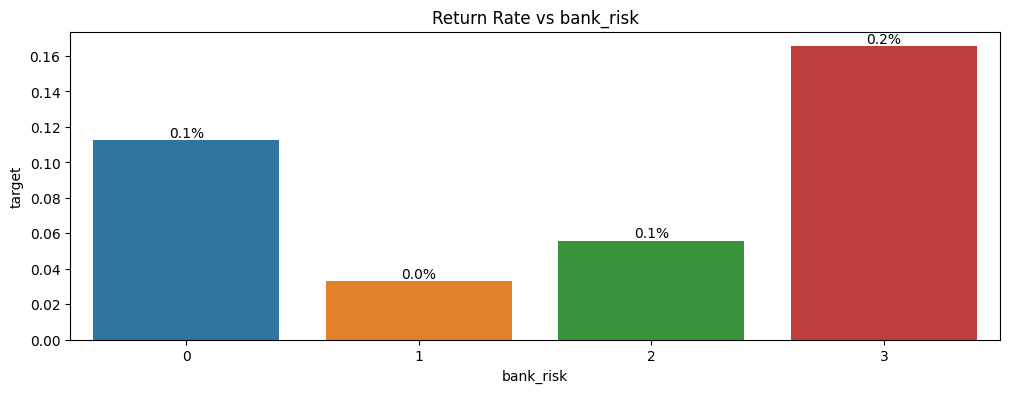

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=df1, x='bank_risk', y='target', ax=ax, ci=None)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
ax.set(title='Return Rate vs bank_risk')

# Modelling

In [12]:
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
import warnings
warnings.filterwarnings("ignore")

# Classifier
from catboost import CatBoostClassifier

# Model selection
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score,f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

### Define Eval Metrics

In [13]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Test Recall', recall_score(y_test, y_pred_test,pos_label=1))
    print('Test Precision', precision_score(y_test, y_pred_test,pos_label=1))
    print('Test F1', f1_score(y_test, y_pred_test,pos_label=1))
    print('Test ROC_AUC',roc_auc_score(y_test, y_pred_test))
    print('Test Accuracy',accuracy_score(y_test, y_pred_test))
    print('Test Confusion Matrix',confusion_matrix(y_test, y_pred_test))
    ConfusionMatrix = confusion_matrix(y_test, y_pred_test)
    defaulters = ConfusionMatrix[1,0]
    success = ConfusionMatrix[0,0]
    default_rate = (ConfusionMatrix[1,0]) / (ConfusionMatrix[1,0] + ConfusionMatrix[0,0])
    print('Test Default Rate : ', default_rate)
    ax = sns.heatmap(ConfusionMatrix, annot=True, cmap='BuPu',fmt=".1f",cbar=False)
    ax.set_title('Confusion Matrix for Test');
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual');
    ax.xaxis.set_ticklabels(['Completed','Return'])
    ax.yaxis.set_ticklabels(['Completed','Return'])
    plt.show()
    
    print()
    
    print('Train Recall', recall_score(y_train, y_pred_train,pos_label=1))
    print('Train Precision', precision_score(y_train, y_pred_train,pos_label=1))
    print('Train F1', f1_score(y_train, y_pred_train,pos_label=1))
    print('Train ROC_AUC',roc_auc_score(y_train, y_pred_train))
    print('Train Accuracy',accuracy_score(y_train, y_pred_train))
    print('Train Confusion Matrix',confusion_matrix(y_train, y_pred_train))
    ConfusionMatrix = confusion_matrix(y_train, y_pred_train)
    defaulters = ConfusionMatrix[1,0]
    success = ConfusionMatrix[0,0]
    default_rate = (ConfusionMatrix[1,0]) / (ConfusionMatrix[1,0] + ConfusionMatrix[0,0])
    print('Train Default Rate : ', default_rate)
    ax = sns.heatmap(ConfusionMatrix, annot=True, fmt=".1f", cmap='BuPu',cbar=False)
    ax.set_title('Confusion Matrix for Train');
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual');
    ax.xaxis.set_ticklabels(['Completed','Return'])
    ax.yaxis.set_ticklabels(['Completed','Return'])
    plt.show()

In [109]:
df2 = df1.copy()

model_cat = df2.loc[(df2['created_at']>='2023-09-01') & (df2['created_at']<'2024-07-01')]
oot_cat = df2.loc[(df2['created_at']>='2024-07-01') & (df2['created_at']<'2024-11-01')]


X = model_cat[['age_business_months','avg_running_balance_past30d','bank_risk','rb_at_deposit','past30d_returned_ach','card_txn_count_past30d','returned_past30d_avg_ach_amount','stddev_running_balance_past30d','ach_c_avg_past30d','od_count_past30d','ach_c_count_past10by30d','amount','ach_c_median_past30d','card_txn_avg_past30d','past30d_avg_ach_amount','debit_txn_count_past10by30d','ach_c_std_past30d','card_txn_median_past10by30d','card_txn_median_past30d','ach_c_median_past10by30d','debit_by_credit_past_30d','rejected_past30d_avg_ach_amount','ein_ssn']]
y = model_cat['target']

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, 
                                                    random_state=42)

x_oot = oot_cat[['age_business_months','avg_running_balance_past30d','bank_risk','rb_at_deposit','past30d_returned_ach','card_txn_count_past30d','returned_past30d_avg_ach_amount','stddev_running_balance_past30d','ach_c_avg_past30d','od_count_past30d','ach_c_count_past10by30d','amount','ach_c_median_past30d','card_txn_avg_past30d','past30d_avg_ach_amount','debit_txn_count_past10by30d','ach_c_std_past30d','card_txn_median_past10by30d','card_txn_median_past30d','ach_c_median_past10by30d','debit_by_credit_past_30d','rejected_past30d_avg_ach_amount','ein_ssn']]
y_oot = oot_cat['target']


In [110]:
x_train.shape

(43496, 23)

In [24]:
# oot_cat.groupby('target')['business_id'].count()
# y_test.sum()

### Hyper Parameter Optimization

In [183]:
import optuna

def hyper_eval(cb, x_train, x_test, y_test, y_train):
    y_train_pred = cb.predict_proba(x_train)
    y_test_pred = cb.predict_proba(x_test)

    y_train_pred1 = pd.DataFrame(data = y_train_pred, columns=['co_prob','canc_prob'])
    y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])
    
    y_test1 = pd.DataFrame(data = y_test, columns=['target'])
    y_train1 = pd.DataFrame(data = y_train, columns=['target'])
    
    # Test at different cutoffs
    prob_threshold =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    test_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision_test', 'Recall_test']

    for bin in prob_threshold:
        test_ls.append(calculate_at_threshold(bin, y_test1['target'], y_test_pred1['canc_prob']))
    metric_df_test = pd.DataFrame(test_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_test.index.name = 'Threshold'
    metric_df_test = metric_df_test.reset_index()
    metric_df_test = metric_df_test[['Threshold','Precision_test','Recall_test']]


    # Train at different cutoffs
    prob_threshold =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    train_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision_train', 'Recall_train']


    for bin in prob_threshold:
        train_ls.append(calculate_at_threshold(bin, y_train1['target'], y_train_pred1['canc_prob']))
    metric_df_train = pd.DataFrame(train_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_train.index.name = 'Threshold'
    metric_df_train = metric_df_train.reset_index()
    metric_df_train = metric_df_train[['Threshold','Precision_train','Recall_train']]
    
    final = pd.merge(metric_df_test,metric_df_train, on = 'Threshold')
    final = final.loc[final['Threshold']==0.1]
    
    return final


In [184]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.01, 0.2, 0.05)
#     param['depth'] = trial.suggest_int('depth', 2, 6) 
    param['depth'] = trial.suggest_discrete_uniform('depth', 2, 6, 1.0)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 40.0, 100.0, 30.0)
#     param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
#     param['grow_policy'] = 'Depthwise'
    param['iterations'] = trial.suggest_categorical('iterations', [400, 500, 700])
#     param['use_best_model'] = True
    param['eval_metric'] = 'AUC'
#     param['od_type'] = 'iter'
#     param['od_wait'] = 50
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
    
    cb = CatBoostClassifier(**param)
    cb.fit(x_train.copy(), y_train.copy(),
                  eval_set=[(x_test.copy(), y_test.copy())],
                  early_stopping_rounds=100)
        
    
    return param,hyper_eval(cb, x_train, x_test, y_test, y_train)

In [185]:
%%time
study = optuna.create_study(study_name='catboost-seed')
study.optimize(objective, n_trials=100, n_jobs=-1, timeout=24000)

[I 2025-01-06 11:10:25,795] A new study created in memory with name: catboost-seed
[W 2025-01-06 11:10:32,892] Trial 3 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 11:10:32,898] Trial 3 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.234275     0.510934         0.241284      0.519126).
[W 2025-01-06 11:10:33,364] Trial 5 failed with parameters: {'learning_rate': 0.01, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 400} because of the following 

[W 2025-01-06 11:10:43,003] Trial 10 failed with value ({'learning_rate': 0.16, 'depth': 6.0, 'l2_leaf_reg': 40.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.246255     0.522863         0.287244      0.613015).
[W 2025-01-06 11:10:43,412] Trial 8 failed with parameters: {'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 11:10:43,418] Trial 8 failed with value ({'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1     

[W 2025-01-06 11:10:55,639] Trial 23 failed with parameters: {'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 11:10:55,643] Trial 23 failed with value ({'learning_rate': 0.16, 'depth': 2.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.237365     0.522863         0.250803      0.542971).
[W 2025-01-06 11:10:56,221] Trial 20 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.060000000000000005, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 700, '

[W 2025-01-06 11:11:08,875] Trial 32 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 4.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.243578     0.508946         0.261426      0.548435).
[W 2025-01-06 11:11:10,315] Trial 34 failed with parameters: {'learning_rate': 0.01, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.01, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 11:11:10,319] Trial 34 failed with value ({'learning_rate': 0.01, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train

[W 2025-01-06 11:11:19,865] Trial 45 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 3.0, 'l2_leaf_reg': 100.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.060000000000000005, 'depth': 3.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 11:11:19,870] Trial 45 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 3.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.240191     0.499006         0.250969      0.514655).
[W 2025-01-06 11:11:20,707] Trial 46 failed with parameters: {'learning_rate': 0.16, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.16, 'depth': 3.0, 'l2_leaf_reg': 40.0, '

[W 2025-01-06 11:11:30,891] Trial 57 failed with value ({'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.242026     0.512922         0.263281      0.558867).
[W 2025-01-06 11:11:33,374] Trial 58 failed with parameters: {'learning_rate': 0.11, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.11, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 11:11:33,381] Trial 58 failed with value ({'learning_rate': 0.11, 'depth': 2.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.

[W 2025-01-06 11:11:43,980] Trial 64 failed with parameters: {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 70.0, 'iterations': 700} because of the following error: The value {'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 11:11:43,989] Trial 64 failed with value ({'learning_rate': 0.11, 'depth': 6.0, 'l2_leaf_reg': 70.0, 'iterations': 700, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.250233     0.532803         0.287518      0.611028).
[W 2025-01-06 11:11:46,627] Trial 70 failed with parameters: {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 70.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_sta

[W 2025-01-06 11:11:56,320] Trial 81 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 3.0, 'l2_leaf_reg': 40.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.238833     0.520875          0.24884      0.533035).
[W 2025-01-06 11:11:58,487] Trial 79 failed with parameters: {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 500} because of the following error: The value {'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 11:11:58,490] Trial 79 failed with value ({'learning_rate': 0.11, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_tr

[W 2025-01-06 11:12:07,820] Trial 91 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 2.0, 'l2_leaf_reg': 40.0, 'iterations': 500, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precision_test  Recall_test  Precision_train  Recall_train
0        0.1        0.234923     0.518887         0.243701      0.528564).
[W 2025-01-06 11:12:09,141] Trial 95 failed with parameters: {'learning_rate': 0.060000000000000005, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 400} because of the following error: The value {'learning_rate': 0.060000000000000005, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'} could not be cast to float.
[W 2025-01-06 11:12:09,144] Trial 95 failed with value ({'learning_rate': 0.060000000000000005, 'depth': 5.0, 'l2_leaf_reg': 100.0, 'iterations': 400, 'eval_metric': 'AUC', 'random_state': 42, 'logging_level': 'Silent'},    Threshold  Precisi

CPU times: user 12min 28s, sys: 11.6 s, total: 12min 39s
Wall time: 1min 45s


### Model Iteration

In [111]:
categoricals = ['bank_risk']

cb = CatBoostClassifier(cat_features=categoricals,
                         eval_metric = 'AUC',
                         depth = 4,
                         iterations = 700,
                         l2_leaf_reg = 100,
                         learning_rate = 0.1,
                        random_state = 42,
                        use_best_model=True)

cb.fit(x_train, y_train, verbose = 1,eval_set = (x_test, y_test))

y_train_pred = cb.predict_proba(x_train)
y_test_pred = cb.predict_proba(x_test)

0:	test: 0.5716269	best: 0.5716269 (0)	total: 17.5ms	remaining: 12.3s
1:	test: 0.5958889	best: 0.5958889 (1)	total: 30.8ms	remaining: 10.7s
2:	test: 0.6070154	best: 0.6070154 (2)	total: 41.7ms	remaining: 9.69s
3:	test: 0.6781981	best: 0.6781981 (3)	total: 52.8ms	remaining: 9.19s
4:	test: 0.7099804	best: 0.7099804 (4)	total: 63.5ms	remaining: 8.82s
5:	test: 0.7276550	best: 0.7276550 (5)	total: 77.1ms	remaining: 8.92s
6:	test: 0.7321046	best: 0.7321046 (6)	total: 88.2ms	remaining: 8.73s
7:	test: 0.7328226	best: 0.7328226 (7)	total: 99ms	remaining: 8.57s
8:	test: 0.7353737	best: 0.7353737 (8)	total: 110ms	remaining: 8.41s
9:	test: 0.7345274	best: 0.7353737 (8)	total: 120ms	remaining: 8.3s
10:	test: 0.7353821	best: 0.7353821 (10)	total: 131ms	remaining: 8.19s
11:	test: 0.7549524	best: 0.7549524 (11)	total: 142ms	remaining: 8.13s
12:	test: 0.7665422	best: 0.7665422 (12)	total: 151ms	remaining: 7.99s
13:	test: 0.7688723	best: 0.7688723 (13)	total: 162ms	remaining: 7.91s
14:	test: 0.7672796	b

121:	test: 0.7947984	best: 0.7948278 (117)	total: 1.5s	remaining: 7.1s
122:	test: 0.7947576	best: 0.7948278 (117)	total: 1.51s	remaining: 7.09s
123:	test: 0.7947576	best: 0.7948278 (117)	total: 1.52s	remaining: 7.07s
124:	test: 0.7947695	best: 0.7948278 (117)	total: 1.53s	remaining: 7.05s
125:	test: 0.7947714	best: 0.7948278 (117)	total: 1.54s	remaining: 7.03s
126:	test: 0.7947714	best: 0.7948278 (117)	total: 1.55s	remaining: 7.01s
127:	test: 0.7947722	best: 0.7948278 (117)	total: 1.56s	remaining: 6.99s
128:	test: 0.7947753	best: 0.7948278 (117)	total: 1.57s	remaining: 6.96s
129:	test: 0.7947779	best: 0.7948278 (117)	total: 1.58s	remaining: 6.93s
130:	test: 0.7947841	best: 0.7948278 (117)	total: 1.59s	remaining: 6.91s
131:	test: 0.7947782	best: 0.7948278 (117)	total: 1.6s	remaining: 6.89s
132:	test: 0.7947866	best: 0.7948278 (117)	total: 1.61s	remaining: 6.88s
133:	test: 0.7947883	best: 0.7948278 (117)	total: 1.62s	remaining: 6.86s
134:	test: 0.7947884	best: 0.7948278 (117)	total: 1.63

241:	test: 0.7989378	best: 0.7989378 (241)	total: 2.72s	remaining: 5.15s
242:	test: 0.7989378	best: 0.7989378 (241)	total: 2.73s	remaining: 5.14s
243:	test: 0.7989479	best: 0.7989479 (243)	total: 2.74s	remaining: 5.13s
244:	test: 0.7989407	best: 0.7989479 (243)	total: 2.75s	remaining: 5.11s
245:	test: 0.7989528	best: 0.7989528 (245)	total: 2.76s	remaining: 5.1s
246:	test: 0.7989528	best: 0.7989528 (245)	total: 2.77s	remaining: 5.08s
247:	test: 0.7989551	best: 0.7989551 (247)	total: 2.78s	remaining: 5.07s
248:	test: 0.7989510	best: 0.7989551 (247)	total: 2.79s	remaining: 5.06s
249:	test: 0.7989515	best: 0.7989551 (247)	total: 2.8s	remaining: 5.05s
250:	test: 0.7989513	best: 0.7989551 (247)	total: 2.81s	remaining: 5.03s
251:	test: 0.7989513	best: 0.7989551 (247)	total: 2.82s	remaining: 5.02s
252:	test: 0.7989512	best: 0.7989551 (247)	total: 2.83s	remaining: 5s
253:	test: 0.7989717	best: 0.7989717 (253)	total: 2.84s	remaining: 4.99s
254:	test: 0.7989757	best: 0.7989757 (254)	total: 2.85s	

357:	test: 0.8002791	best: 0.8003880 (320)	total: 3.94s	remaining: 3.77s
358:	test: 0.8002791	best: 0.8003880 (320)	total: 3.95s	remaining: 3.75s
359:	test: 0.8002587	best: 0.8003880 (320)	total: 3.96s	remaining: 3.74s
360:	test: 0.8002871	best: 0.8003880 (320)	total: 3.97s	remaining: 3.73s
361:	test: 0.8002820	best: 0.8003880 (320)	total: 3.98s	remaining: 3.72s
362:	test: 0.8002642	best: 0.8003880 (320)	total: 4s	remaining: 3.71s
363:	test: 0.8002721	best: 0.8003880 (320)	total: 4.01s	remaining: 3.7s
364:	test: 0.8002785	best: 0.8003880 (320)	total: 4.02s	remaining: 3.69s
365:	test: 0.8002722	best: 0.8003880 (320)	total: 4.05s	remaining: 3.69s
366:	test: 0.8002821	best: 0.8003880 (320)	total: 4.08s	remaining: 3.7s
367:	test: 0.8002746	best: 0.8003880 (320)	total: 4.09s	remaining: 3.69s
368:	test: 0.8002799	best: 0.8003880 (320)	total: 4.11s	remaining: 3.68s
369:	test: 0.8002799	best: 0.8003880 (320)	total: 4.13s	remaining: 3.68s
370:	test: 0.8002814	best: 0.8003880 (320)	total: 4.15s	

479:	test: 0.8007433	best: 0.8013219 (410)	total: 5.35s	remaining: 2.45s
480:	test: 0.8007198	best: 0.8013219 (410)	total: 5.37s	remaining: 2.44s
481:	test: 0.8007186	best: 0.8013219 (410)	total: 5.38s	remaining: 2.43s
482:	test: 0.8006923	best: 0.8013219 (410)	total: 5.39s	remaining: 2.42s
483:	test: 0.8008561	best: 0.8013219 (410)	total: 5.4s	remaining: 2.41s
484:	test: 0.8009114	best: 0.8013219 (410)	total: 5.41s	remaining: 2.4s
485:	test: 0.8009089	best: 0.8013219 (410)	total: 5.42s	remaining: 2.38s
486:	test: 0.8009150	best: 0.8013219 (410)	total: 5.43s	remaining: 2.37s
487:	test: 0.8009425	best: 0.8013219 (410)	total: 5.44s	remaining: 2.36s
488:	test: 0.8009606	best: 0.8013219 (410)	total: 5.45s	remaining: 2.35s
489:	test: 0.8012570	best: 0.8013219 (410)	total: 5.46s	remaining: 2.34s
490:	test: 0.8012377	best: 0.8013219 (410)	total: 5.47s	remaining: 2.33s
491:	test: 0.8012429	best: 0.8013219 (410)	total: 5.48s	remaining: 2.32s
492:	test: 0.8012314	best: 0.8013219 (410)	total: 5.4

599:	test: 0.8017160	best: 0.8019402 (579)	total: 6.59s	remaining: 1.1s
600:	test: 0.8017153	best: 0.8019402 (579)	total: 6.6s	remaining: 1.09s
601:	test: 0.8016569	best: 0.8019402 (579)	total: 6.62s	remaining: 1.08s
602:	test: 0.8016796	best: 0.8019402 (579)	total: 6.63s	remaining: 1.07s
603:	test: 0.8016843	best: 0.8019402 (579)	total: 6.64s	remaining: 1.05s
604:	test: 0.8018385	best: 0.8019402 (579)	total: 6.65s	remaining: 1.04s
605:	test: 0.8018357	best: 0.8019402 (579)	total: 6.66s	remaining: 1.03s
606:	test: 0.8018393	best: 0.8019402 (579)	total: 6.67s	remaining: 1.02s
607:	test: 0.8018256	best: 0.8019402 (579)	total: 6.68s	remaining: 1.01s
608:	test: 0.8017896	best: 0.8019402 (579)	total: 6.7s	remaining: 1s
609:	test: 0.8017917	best: 0.8019402 (579)	total: 6.7s	remaining: 989ms
610:	test: 0.8017908	best: 0.8019402 (579)	total: 6.71s	remaining: 978ms
611:	test: 0.8018912	best: 0.8019402 (579)	total: 6.72s	remaining: 967ms
612:	test: 0.8018834	best: 0.8019402 (579)	total: 6.74s	re

### Importance

In [112]:
# cb.get_feature_importance()
print(cb.get_feature_importance())
arr_imp_cb = cb.get_feature_importance()
pd.DataFrame(arr_imp_cb)

[ 5.63964803 11.1527761  17.85875183  6.62751931  1.0210204   2.06951919
  1.67134064  4.06525272  2.4890574   1.27965335  2.33335274 11.02272319
  2.35506661  1.20664445  5.53860989  2.45454362  1.5182416   1.27270669
  0.91851153  0.99737206  2.24094035 12.70089635  1.56585196]


,0
0,5.639648
1,11.152776
2,17.858752
3,6.627519
4,1.021020
5,2.069519
6,1.671341
7,4.065253
8,2.489057
9,1.279653


### Scoring

In [113]:
y_train_pred = cb.predict_proba(x_train)
y_test_pred = cb.predict_proba(x_test)
y_oot_pred = cb.predict_proba(x_oot)

y_train_pred1 = pd.DataFrame(data = y_train_pred, columns=['co_prob','canc_prob'])
y_train_pred_fin = np.where((y_train_pred1["canc_prob"]<0.08),0,1)

y_test_pred1 = pd.DataFrame(data = y_test_pred, columns=['co_prob','canc_prob'])
y_test_pred_fin = np.where((y_test_pred1["canc_prob"]<0.08),0,1)

y_oot_pred1 = pd.DataFrame(data = y_oot_pred, columns=['co_prob','canc_prob'])
y_oot_pred_fin = np.where((y_oot_pred1["canc_prob"]<0.08),0,1)


### Metrics

In [62]:
from sklearn.metrics import precision_recall_curve,precision_score,confusion_matrix, recall_score, roc_curve, plot_roc_curve
def calculate_at_threshold(threshold, actual, predicted):
  p = np.where(predicted >= threshold, 1, 0)
  fp = np.sum((p == 1) & (actual == 0))
  tp = np.sum((p == 1) & (actual == 1))
  fn = np.sum((p == 0) & (actual == 1))
  tn = np.sum((p == 0) & (actual == 0))
  tpr = (tp)/(tp + fn)
  fpr = (fp)/(fp + tn)
  precision = (tp)/(tp + fp)
  recall = (tp)/(tp + fn)
  return fp,tp,fn,tn,tpr,fpr,precision, recall

### Metrics OOT

In [63]:
# OOT at different cutoffs
prob_threshold =[0.03,0.04,0.05,0.06,0.08,0.1,0.20,0.3,0.4]
oot_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']


for bin in prob_threshold:
    oot_ls.append(calculate_at_threshold(bin, oot_cat['target'], y_oot_pred1['canc_prob']))
metric_df_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_oot.index.name = 'Threshold'
metric_df_oot = metric_df_oot.reset_index()
metric_df_oot

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.03,13480,839,95,8833,0.898287,0.604132,0.058593,0.898287
1,0.04,7425,652,282,14888,0.698073,0.332766,0.080723,0.698073
2,0.05,5218,583,351,17095,0.624197,0.233855,0.100500,0.624197
3,0.06,3877,506,428,18436,0.541756,0.173755,0.115446,0.541756
4,0.08,2793,448,486,19520,0.479657,0.125174,0.138229,0.479657
5,0.10,2056,409,525,20257,0.437901,0.092144,0.165923,0.437901
6,0.20,377,127,807,21936,0.135974,0.016896,0.251984,0.135974
7,0.30,177,84,850,22136,0.089936,0.007933,0.321839,0.089936
8,0.40,72,52,882,22241,0.055675,0.003227,0.419355,0.055675


### Amount blocked at different cutoffs (OOT)

In [53]:
# OOT Data
dummy1 = oot_cat[['amount','target']]
dummy1 = dummy1.reset_index()
dummy2 = pd.merge(dummy1, y_oot_pred1, left_index=True, right_index=True)

print('OOT All')
print()
prob_threshold =[0.0,0.03,0.04,0.05,0.06,0.08,0.1,0.20,0.3,0.4]
for bin in prob_threshold:
    dummy3 = dummy2.loc[dummy2['canc_prob']>=bin]
    print(dummy3.amount.sum())

print()    
print('OOT Fraud')
print()
for bin in prob_threshold:
    dummy3 = dummy2.loc[(dummy2['canc_prob']>=bin) & (dummy2['target']==1)]
    print(dummy3.amount.sum())

print()
print('OOT Non Fraud')
print()
for bin in prob_threshold:
    dummy3 = dummy2.loc[(dummy2['canc_prob']>=bin) & (dummy2['target']==0)]
    print(dummy3.amount.sum())

OOT All

7216516.4
4016284.2600000007
2881980.94
2410611.8200000003
1888007.7100000002
1408044.9
878279.99
299565.99
172448.99
93740.4

OOT Fraud

258702.22000000003
231738.2
206754.03
198028.16000000003
182664.03999999998
165053.19
135082.75
77766.62
58203.630000000005
42174.63

OOT Non Fraud

6957814.18
3784546.06
2675226.91
2212583.66
1705343.67
1242991.71
743197.24
221799.37
114245.36
51565.770000000004


### Capture Rate (OOT)

In [54]:
dummy2['flag'] = np.where((dummy2['canc_prob'] >= 0) &(dummy2['canc_prob'] < 0.015), '1',
                          np.where((dummy2['canc_prob'] >= 0.015) &(dummy2['canc_prob'] < 0.03), '2',
                          np.where((dummy2['canc_prob'] >= 0.03) &(dummy2['canc_prob'] < 0.06), '3',
                          np.where((dummy2['canc_prob'] >= 0.06) &(dummy2['canc_prob'] < 0.15), '4',
                          np.where((dummy2['canc_prob'] >= 0.15) &(dummy2['canc_prob'] < 0.3), '5',
                          np.where((dummy2['canc_prob'] >= 0.3) &(dummy2['canc_prob'] < 1), '6',
#                           np.where((dummy2['canc_prob'] >= 0.25) &(dummy2['canc_prob'] < 1.1), '7',
                          '0'))))))

dummy2.groupby('flag').mean()

,index,amount,target,co_prob,canc_prob
flag,,,,,
1,99012.379525,324.959940,0.007068,0.990026,0.009974
2,99060.760947,376.004062,0.014969,0.978278,0.021722
3,99899.079481,221.119642,0.033039,0.961655,0.038345
4,99516.036053,448.294345,0.073688,0.904383,0.095617
5,98324.579198,284.400763,0.192748,0.812575,0.187425
6,101219.940075,645.876367,0.303371,0.549305,0.450695


In [55]:
dummy2.groupby('flag')['target'].count()

flag
1    4669
2    4476
3    9625
4    3162
5    1048
6     267
Name: target, dtype: int64

### Metrics (Train)

In [56]:
# Train at different cutoffs
prob_threshold =[0.03,0.04,0.05,0.06,0.08,0.1,0.20,0.3,0.4]
train_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

y_train1 = pd.DataFrame(data = y_train, columns=['target'])

model_cat_df = model_cat.copy()
for bin in prob_threshold:
    train_ls.append(calculate_at_threshold(bin, y_train1['target'], y_train_pred1['canc_prob']))
metric_df_train = pd.DataFrame(train_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_train.index.name = 'Threshold'
metric_df_train = metric_df_train.reset_index()
metric_df_train

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.03,24073,2385,216,16822,0.916955,0.588654,0.090143,0.916955
1,0.04,15250,2104,497,25645,0.808920,0.372906,0.121240,0.808920
2,0.05,12772,2009,592,28123,0.772395,0.312312,0.135918,0.772395
3,0.06,9082,1815,786,31813,0.697809,0.222081,0.166560,0.697809
4,0.08,6372,1623,978,34523,0.623991,0.155814,0.203002,0.623991
5,0.10,4692,1455,1146,36203,0.559400,0.114733,0.236701,0.559400
6,0.20,985,803,1798,39910,0.308727,0.024086,0.449105,0.308727
7,0.30,432,626,1975,40463,0.240677,0.010564,0.591682,0.240677
8,0.40,162,463,2138,40733,0.178008,0.003961,0.740800,0.178008


### Metrics (Test)

In [57]:
# Train at different cutoffs
prob_threshold =[0.03,0.04,0.05,0.06,0.08,0.1,0.20,0.3,0.4]
test_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

y_test1 = pd.DataFrame(data = y_test, columns=['target'])

# model_cat_df = model_cat.copy()
for bin in prob_threshold:
    test_ls.append(calculate_at_threshold(bin, y_test1['target'], y_test_pred1['canc_prob']))
metric_df_test = pd.DataFrame(test_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_test.index.name = 'Threshold'
metric_df_test = metric_df_test.reset_index()
metric_df_test

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.03,5968,578,72,4256,0.889231,0.583725,0.088298,0.889231
1,0.04,3765,496,154,6459,0.763077,0.368251,0.116405,0.763077
2,0.05,3144,478,172,7080,0.735385,0.307512,0.131971,0.735385
3,0.06,2236,425,225,7988,0.653846,0.218701,0.159714,0.653846
4,0.08,1598,377,273,8626,0.580000,0.156299,0.190886,0.580000
5,0.10,1142,340,310,9082,0.523077,0.111698,0.229420,0.523077
6,0.20,271,166,484,9953,0.255385,0.026506,0.379863,0.255385
7,0.30,140,115,535,10084,0.176923,0.013693,0.450980,0.176923
8,0.40,67,83,567,10157,0.127692,0.006553,0.553333,0.127692


In [58]:
oot_cat_c = oot_cat.copy()
oot_cat_c = oot_cat_c.reset_index(drop=True)

oot_cat_pred = pd.merge(oot_cat_c, y_oot_pred1,left_index=True, right_index=True)
oot_cat_pred['flag'] = np.where((oot_cat_pred['canc_prob'] >= 0.08), '1','0')
oot_cat_pred.groupby(['flag','status'])['amount'].count()


flag  status   
0     completed    19496
      rejected       111
      returned       368
1     completed     2817
      rejected       115
      returned       340
Name: amount, dtype: int64

In [59]:
oot_cat_pred.shape

(23247, 43)

## LTV Addition

In [60]:
ltv_q = '''
select business_id, REVENUE_LTV, CONTRIBUTION_LTV, DATE_OF_ESTIMATE
from "PROD_DB"."MODELS"."HISTORIC_CUSTOMER_VALUE_ESTIMATES"
'''

ltv = get_data(conn, ltv_q)

ltv.columns = ltv.columns.str.lower()
ltv.head(2)

,business_id,revenue_ltv,contribution_ltv,date_of_estimate
0,52836128-52c4-4860-96df-fef1de890438,0.000000,-31.38000,2023-12-01
1,39b8a13d-230a-41c7-8ae6-f18cd6dad28b,246.619703,58.83117,2023-12-01


In [61]:
oot_cat_pred['date_of_estimate'] = pd.to_datetime(oot_cat_pred['created_at'])

oot_cat_pred['date_of_estimate'] = oot_cat_pred['date_of_estimate'].apply(lambda x: x.replace(day=1))
oot_cat_pred['date_of_estimate'] = oot_cat_pred['date_of_estimate'].dt.date

oot_pred_ltv = pd.merge(oot_cat_pred, ltv, how='left', on=['date_of_estimate','business_id'])

print(oot_pred_ltv.shape)
print(oot_cat_pred.shape)

(23247, 46)
(23247, 44)


In [62]:
oot_pred_ltv['flag'] = np.where(((oot_pred_ltv['canc_prob']>0.06) 
             & ((oot_pred_ltv['contribution_ltv']<100000) | (oot_pred_ltv['contribution_ltv'].isna())) ), '1','0')

oot_pred_ltv.groupby(['flag','status'])['amount'].count().reset_index(name='count')

,flag,status,count
0,0,completed,18352
1,0,rejected,93
2,0,returned,325
3,1,completed,3961
4,1,rejected,133
5,1,returned,383


In [63]:
fraud = pd.read_csv('/Users/saliljain/Documents/salil/ACH_Pull_Refresh/fraud_business_id.csv')
fraud.columns = fraud.columns.str.lower()
fraud1 = pd.merge(oot_pred_ltv,fraud, on='business_id')

In [64]:
fraud1.groupby(['flag','status'])['amount'].sum().reset_index(name='count')

,flag,status,count
0,0,completed,3275.00
1,0,returned,3979.55
2,1,completed,13366.10
3,1,rejected,9969.00
4,1,returned,41479.19


In [405]:
fraud1.head()

,id,business_id,amount,created_at,updated_at,status,target,avg_running_balance_past30d,stddev_running_balance_past30d,od_count_past30d,zero_balance_count_past30d,rb_at_deposit,business_type,ein_ssn,age_business_months,card_txn_count_past30d,card_txn_median_past30d,card_txn_avg_past30d,ach_c_count_past30d,ach_c_median_past30d,ach_c_avg_past30d,ach_c_std_past30d,debit_by_credit_past_30d,ach_d_median_past30d,ach_d_avg_past30d,debit_by_credit_past_10d,card_txn_avg_past10d,card_txn_median_past2d,card_txn_median_past10by30d,ach_c_count_past10by30d,ach_c_avg_past10by30d,debit_txn_count_past10by30d,ach_c_median_past10by30d,past30d_ach_count,completed_past30d_std_ach_amount,past30d_avg_ach_amount,past30d_returned_ach,returned_past30d_avg_ach_amount,rejected_past30d_avg_ach_amount,bank_risk,co_prob,canc_prob,flag,date_of_estimate,revenue_ltv,contribution_ltv,ach_loss
0,a92e86d5-6277-4b4e-8a2a-bcc082a7fa10,983d9481-de70-41cc-bb76-acbf40ce9669,2.0,2024-07-25 07:01:03.015000+00:00,2024-07-30 13:00:03.864832+00:00,returned,1,0.00,NaN,0,1,0.00,llc,0.0,0.000000,0,0.0,0.000000,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,NaN,0.000000,NaN,0.0,NaN,0,0.0,0.0,0,0.0,0.0,3,0.823985,0.176015,1,2024-07-01,NaN,NaN,1.85
1,5b8f31ba-8005-4b93-94c2-4858245c8d8f,70cebeb3-53ec-43cd-80b0-ccae2e7d9380,1250.0,2024-08-07 19:20:23.247000+00:00,2024-08-13 11:55:35.969174+00:00,returned,1,0.00,NaN,0,1,0.00,llc,1.0,0.000000,0,0.0,0.000000,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,NaN,0.000000,NaN,0.0,NaN,0,0.0,0.0,0,0.0,0.0,3,0.490405,0.509595,1,2024-08-01,NaN,NaN,2959.67
2,e336f1eb-6dba-4955-af9e-69b374f6173a,d50f308e-d4f3-4410-b13d-c576f6fa2882,1250.0,2024-07-31 20:05:37.202000+00:00,2024-08-14 12:49:46.229905+00:00,returned,1,0.00,NaN,0,1,0.00,corporation,0.0,0.000000,0,0.0,0.000000,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,NaN,0.000000,NaN,0.0,NaN,0,0.0,0.0,0,0.0,0.0,1,0.915058,0.084942,1,2024-07-01,NaN,NaN,2480.00
3,b10f5ee2-6e29-4ccb-8030-74cf52826480,f26ea771-3127-4bd2-97df-a117f6caa892,1199.0,2024-09-11 15:05:29.187000+00:00,2024-09-12 18:00:23.678797+00:00,completed,0,632.32,1034.316511,0,1,1229.94,llc,0.0,0.451613,9,700.0,392.070667,6,1179.5,394.533333,471.210215,1.5,0.0,0.0,1.8,420.075714,1181.0,1.0,0.833333,1.066902,1.0,1.001272,1,0.0,25.0,0,0.0,0.0,1,0.861317,0.138683,1,2024-09-01,108.753299,-29.881654,5872.06
4,09b1a13e-9a5c-4331-98f0-f3024bd3d513,95aa3a34-6e38-40dd-8bb9-449cd99c1981,600.0,2024-07-02 08:23:47.305000+00:00,2024-07-08 11:32:56.036066+00:00,returned,1,0.00,NaN,0,1,0.00,llc,0.0,0.000000,0,0.0,0.000000,0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,NaN,0.000000,NaN,0.0,NaN,0,0.0,0.0,0,0.0,0.0,3,0.779180,0.220820,1,2024-07-01,NaN,NaN,599.24


# Bureau Data

In [82]:
query_b = """
select *
from "PROD_DB"."CREDIT"."EXPERIAN_CREDIT_REPORT"
where TRADE_BASE_DATE='2024-07-31'
"""

bureau = get_data(conn, query_b)

bureau.columns = bureau.columns.str.lower()
bureau.head(2)

,business_id,user_id,address_mismatch_flag,val_error_code,val_cat_code,dup_pin_in,security_alert_ind,consumer_stmt_ind,deceased_flag,deceased_flag_,trade_base_date,xyf01,xyf02,xyf03,xyf04,xyf05,xyf06,xyf07,security_alert_date1,security_alert_date2,sec_alert_phone1,sec_alert_phone2,sec_alert_phone3,sec_alert_type_cd,fico_risk_v8,fico_risk_v8_f1,fico_risk_v8_f2,fico_risk_v8_f3,fico_risk_v8_f4,fico_risk_v8_f5,auto_trades_monthly_payment_l3m,avg_lifespan_auto_trade,avg_months_since_bankcard_trades_opened,avg_months_since_cc_trades_opened,avg_months_since_cru_trades_opened,avg_months_since_ever_90plus_opened,avg_months_since_open_fpd_ex_col,avg_months_since_recent_30plus_dq,avg_months_since_recent_60plus_dq,avg_months_since_revolving_opened,bal_bc_util_40_l12m_worse_l24m,balance_auto_loan_trades_l3m,balance_oldest_auto_trade,balance_to_credit_ratio_opened_l30d,bankcards_30less_dpd_30_60_dpd_l12m,days_btwn_first_last_inquiry_l6m,days_since_revolving_inquiry,shortest_trade_lifespan_ex_col,longest_trade_lifespan_ex_col,max_balance_open_installment_trades_l3m,max_balance_to_credit_ratio_open_l3m,max_credit_amount_mortgage_trades,max_payment_open_mortgage_l3m,months_since_30_180dpd_auto_trade,months_since_30dpd_dq_installment,months_since_60dpd_dq_installment,months_since_90plus_dq_bankcard,months_since_cured_30_180dpd_l24m,months_since_last_charge_off,months_since_most_recent_auto_repo,months_since_most_recent_auto_trade_ind,months_since_most_recent_auto_trade_opened,months_since_most_recent_chargeoff,months_since_most_recent_closed_refin_mortgage,months_since_most_recent_derog,months_since_most_recent_mortgage_foreclosed,months_since_most_recent_mortgage_opened,months_since_most_recent_mortgage_refi,months_since_most_recent_open_auto_trade,months_since_most_recent_open_mortage_opened,months_since_most_recent_opened_trade,months_since_most_recent_present_repo,months_since_most_recent_unsat_auto_trade,months_since_oldest_90_180dpd_dq,months_since_oldest_cc_opened,months_since_oldest_ever_90dpd_opened,months_since_oldest_ever_90dpd_opened_ex_col,months_since_oldest_never_dq_trade_opened,months_since_oldest_per_fin_trade_opened,months_since_oldest_revolving_opened,months_since_recent_30dpd,months_since_recent_30dpd_ex_col,months_since_recent_utility_collection,months_since_retail_inquiry_ex_l14d,months_since_revolving_inquiry,overall_balance_to_credit_ratio_l3m,pct_installment_trades_never_dq_l6m,pct_trades_30plus_dpd_l6m,pct_trades_60plus_l36m_30plus_l24m,pct_trades_ever_90_dpd_derog,pct_trades_open_installment_l3m,pct_trades_opened_l12m,pct_trades_opened_l24m,pct_trades_opened_l6m,pct_trades_reported_l3m_ex_col,tota_mortgage_trades_opened_l6m,total_30dpd_dq_instances_installment_l12m,total_30dpd_dq_l24_installment,total_30plus_dq_l24m_auto,total_60dpd_dq_instances_installment_l12m,total_60dpd_dq_l24m_installment,total_90_180dpd_dqs_installment_l12m,total_90_180dpd_dqs_l24m_installment,total_amount_installment_30dpd_l6m,total_amount_installment_60dpd_l6m,total_amount_installment_90_180dpd_l6m,total_amount_pd_30dpd_l6m,total_amount_pd_60dpd_l6m,total_amount_pd_90_180dpd_l6m,total_amount_revolve_30dpd_l6m,total_amount_revolve_60dpd_l6m,total_amount_revolve_90_180dpd_l6m,total_auto_inquiries_l12m,total_auto_inquiries_l12m_nd,total_auto_inquiries_l3m,total_auto_loan_trades,total_auto_trades_60_plus_dpd,total_auto_trades_60dpd_deteriorating,total_auto_trades_opened_l12m,total_auto_trades_opened_l24m,total_auto_trades_opened_l6m,total_available_credit_limit_bankcard_l3m,total_balance_30plus_dpd_l6m,total_balance_60plus_dpd_l6m,total_balance_90plus_dpd_l6m,total_balance_bankcard_charge_trades_l3m,total_balance_bz_loc_cc_l3m,total_balance_collections,total_balance_derog_installment_l6m,total_balance_ever_chargedoff,total_balance_foreclosed_mortgages,total_balance_heloc_l3m,total_balance_installment_30dpd_l6m,total_balance_installment_60dpd_l6m,total_balance_installment_90_180dpd_l6m,total_balance_installment_trades,total_balance_l12m_worse_than_

In [83]:
bureau.drop(columns=['user_id','address_mismatch_flag','val_error_code',
                              'val_cat_code','dup_pin_in','security_alert_ind','consumer_stmt_ind',
                              'deceased_flag','deceased_flag_','trade_base_date','xyf01','xyf02','xyf03',
                              'xyf04','xyf05','xyf06','xyf07','security_alert_date1','security_alert_date2',
                              'sec_alert_phone1','sec_alert_phone2','sec_alert_phone3','sec_alert_type_cd',
                              'request_date','created_at'], inplace=True)

bureau.iloc[:, 1:] = bureau.iloc[:, 1:].astype(float)
bureau.dtypes

In [96]:
oot_bureau = pd.merge(oot_cat_pred,bureau, on='business_id')
print(oot_bureau.shape)
print(oot_cat_pred.shape)

(9473, 347)
(23247, 44)


In [97]:
oot_cat_pred.groupby('target')['business_id'].count()

target
0    22313
1      934
Name: business_id, dtype: int64

## Benchmarking

In [382]:
prod_q = '''
select pfr_id, 
output:decision as decision,
output:score as score,
input:accountAge as accountAge, model
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."ACH_PULL_DECISIONING_SCORES"
where model in ('ds_model_greater_6_months','ds_model_less_6_months')
'''

prod = get_data(conn, prod_q)

prod.columns = prod.columns.str.lower()
prod.head(2)

,pfr_id,decision,score,accountage,model
0,cc7aa1e2-ecf1-4aa2-81bd-de5b36f847ef,"""authorized""",0.019990910127648403,39.90248911033951,ds_model_greater_6_months
1,98da0eea-8a24-4b42-83ed-dc0a498b434a,"""authorized""",0.009989928234406862,33.55071463560335,ds_model_greater_6_months


In [383]:
benchmark1 = oot_cat[['id','target','amount']].copy()
benchmark2 = pd.merge(benchmark1,prod, left_on='id',right_on='pfr_id')
benchmark2['score'] = benchmark2['score'].astype('float')


In [384]:
# OOT at different cutoffs
prob_threshold =[0.03,0.04,0.05,0.06,0.08,0.1,0.20,0.3,0.4]
oot_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall']

for bin in prob_threshold:
    oot_ls.append(calculate_at_threshold(bin, benchmark2['target'], benchmark2['score']))
bench_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
bench_oot.index.name = 'Threshold'
bench_oot = bench_oot.reset_index()
bench_oot

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall
0,0.03,10053,501,421,12095,0.543384,0.453901,0.047470,0.543384
1,0.04,8775,478,444,13373,0.518438,0.396198,0.051659,0.518438
2,0.05,7463,463,459,14685,0.502169,0.336960,0.058415,0.502169
3,0.06,6290,438,484,15858,0.475054,0.283999,0.065101,0.475054
4,0.08,3490,201,721,18658,0.218004,0.157576,0.054457,0.218004
5,0.10,1930,136,786,20218,0.147505,0.087141,0.065828,0.147505
6,0.20,174,36,886,21974,0.039046,0.007856,0.171429,0.039046
7,0.30,46,21,901,22102,0.022777,0.002077,0.313433,0.022777
8,0.40,21,5,917,22127,0.005423,0.000948,0.192308,0.005423


In [390]:
benchmark2['flag'] = np.where((benchmark2['score'] >= 0) &(benchmark2['score'] < 0.015), '1',
                          np.where((benchmark2['score'] >= 0.015) &(benchmark2['score'] < 0.04), '2',
                          np.where((benchmark2['score'] >= 0.03) &(benchmark2['score'] < 0.06), '3',
                          np.where((benchmark2['score'] >= 0.06) &(benchmark2['score'] < 0.15), '4',
                          np.where((benchmark2['score'] >= 0.15) &(benchmark2['score'] < 0.3), '5',
                          np.where((benchmark2['score'] >= 0.3) &(benchmark2['score'] < 1), '6',
                          '0'))))))

benchmark2.groupby('flag').count()
benchmark2.groupby('flag')['target'].sum()

flag
1    173
2    271
3     40
4    365
5     52
6     21
Name: target, dtype: int64

In [387]:
# OOT Data
benchmark2 = benchmark2[['amount','target','score']]


print('OOT All')
print()
prob_threshold =[0.0,0.03,0.04,0.05,0.06,0.08,0.1,0.20,0.3,0.4]
for bin in prob_threshold:
    benchmark3 = benchmark2.loc[benchmark2['score']>=bin]
    print(benchmark3.amount.sum())

print()    
print('OOT Fraud')
print()
for bin in prob_threshold:
    benchmark3 = benchmark2.loc[(benchmark2['score']>=bin) & (benchmark2['target']==1)]
    print(benchmark3.amount.sum())

OOT All

7161753.74
4137181.81
3479869.0300000003
2959671.33
2459760.76
1468506.6099999999
809475.6200000001
55969.229999999996
16555.41
4070.42

OOT Fraud

252130.22
161305.27
150354.36
143398.74
128236.27
89402.31999999999
56095.88
14605.01
5924.43
376.44


# Validation

### PSI

In [27]:
prod_train = pd.read_csv('/Users/saliljain/Documents/git/ACH_Pull_fraud_model/data_updated/less_6_months/training/x_train_less_6_months.csv')
prod_train.shape

(39891, 22)

In [33]:
#PSI calculation
import pandas as pd
import numpy as np
import math as math
import sys as sys
import logging


name =['avg_running_balance_past30d','bank_risk','rb_at_deposit','past30d_returned_ach','card_txn_count_past30d','returned_past30d_avg_ach_amount','stddev_running_balance_past30d','ach_c_avg_past30d','od_count_past30d','ach_c_count_past10by30d','amount','ach_c_median_past30d','card_txn_avg_past30d','past30d_avg_ach_amount','debit_txn_count_past10by30d','ach_c_std_past30d','card_txn_median_past10by30d','card_txn_median_past30d','ach_c_median_past10by30d','debit_by_credit_past_30d','rejected_past30d_avg_ach_amount','ein_ssn']
score_file_old = x_train.copy()
score_file_new = x_oot.copy()


for m in range(len(name)):
    bin_count_input = 5

    pred_score=pd.DataFrame()
    pred_score["y_predict"]=score_file_old[name[m]]


    Ndiv=int(bin_count_input)
    N=len(pred_score)
    bin_obs_1=[int(N/Ndiv)] * Ndiv
    bin_obs_2=[1]*(N%Ndiv) + [0]*(Ndiv-(N%Ndiv))

    dN=[]
    for i in range(Ndiv):
        dN.append(bin_obs_1[i] + bin_obs_2[i])

    pred_score["sr_no"] = pred_score.index.tolist()  #0 indexed sr_no

    pred_score_sorted = pred_score.sort_values(by=["y_predict","sr_no"],ascending=False).reset_index().drop(columns=["sr_no"])

    istart=0
    iend=0
    pred_min_list=[]
    pred_max_list=[]
    for i in range(Ndiv):
        iend=iend+dN[i]
        pred_min_list.append(min(pred_score_sorted.iloc[istart:iend,pred_score_sorted.columns.get_loc("y_predict")]))
        pred_max_list.append(max(pred_score_sorted.iloc[istart:iend,pred_score_sorted.columns.get_loc("y_predict")]))
        istart=iend

    pred_min_list[Ndiv-1]=float("-inf")

    for i in range(Ndiv-1):
        pred_max_list[i+1]=pred_min_list[i]

    pred_max_list[0]=float("inf")

    pred_score_new=pd.DataFrame()

    pred_score_new["y_predict"]=score_file_new[name[m]]
    pred_score_new = pred_score_new.fillna(-99999)
    pred_score_new = pred_score_new[(pred_score_new.y_predict != -99999)]

    obs_new_vs_old=pd.DataFrame(data=np.NaN,index=range(Ndiv),columns=["bin","min(inclusive)","max(exclusive)","new_obs","old_obs","PSI"])

    for i in range(Ndiv):
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("bin")]=str(int(i+1))
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("min(inclusive)")]=pred_min_list[i]
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("max(exclusive)")]=pred_max_list[i]
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]=int(pred_score_sorted["y_predict"][(pred_score_sorted["y_predict"]>=pred_min_list[i]) & (pred_score_sorted["y_predict"]<pred_max_list[i])].count())
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]=int(pred_score_new["y_predict"][(pred_score_new["y_predict"]>=pred_min_list[i]) & (pred_score_new["y_predict"]<pred_max_list[i])].count())

    total_old=obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("old_obs")].sum()
    total_new=obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("new_obs")].sum()
    

    for i in range(Ndiv):
        obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("PSI")]=(obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]/total_old-obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]/total_new)*math.log((obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("old_obs")]/total_old)/(obs_new_vs_old.iloc[i,obs_new_vs_old.columns.get_loc("new_obs")]/total_new))

    output={'Variable':name[m],'PSI':obs_new_vs_old.iloc[:,obs_new_vs_old.columns.get_loc("PSI")].sum()}
    print(output)
    

{'Variable': 'avg_running_balance_past30d', 'PSI': 0.02681253382128572}
{'Variable': 'bank_risk', 'PSI': 0.07712750077426789}
{'Variable': 'rb_at_deposit', 'PSI': 0.02712935617558563}
{'Variable': 'past30d_returned_ach', 'PSI': 0.0}
{'Variable': 'card_txn_count_past30d', 'PSI': 0.0003430479709943074}
{'Variable': 'returned_past30d_avg_ach_amount', 'PSI': 0.0}
{'Variable': 'stddev_running_balance_past30d', 'PSI': 0.00012263485424329746}
{'Variable': 'ach_c_avg_past30d', 'PSI': 0.005883757899608157}
{'Variable': 'od_count_past30d', 'PSI': 0.0}
{'Variable': 'ach_c_count_past10by30d', 'PSI': 0.004161029088091872}
{'Variable': 'amount', 'PSI': 0.015536965693006393}
{'Variable': 'ach_c_median_past30d', 'PSI': 0.005287164767439297}
{'Variable': 'card_txn_avg_past30d', 'PSI': 4.735707581000652e-05}
{'Variable': 'past30d_avg_ach_amount', 'PSI': 0.008080959834298199}
{'Variable': 'debit_txn_count_past10by30d', 'PSI': 0.0034237755337122103}
{'Variable': 'ach_c_std_past30d', 'PSI': 0.0032679745298

### Seed Analysis

In [52]:
def calculate_seed(threshold, actual, predicted,rand1,rand2):
  p = np.where(predicted >= threshold, 1, 0)
  fp = np.sum((p == 1) & (actual == 0))
  tp = np.sum((p == 1) & (actual == 1))
  fn = np.sum((p == 0) & (actual == 1))
  tn = np.sum((p == 0) & (actual == 0))
  tpr = (tp)/(tp + fn)
  fpr = (fp)/(fp + tn)
  precision = (tp)/(tp + fp)
  recall = (tp)/(tp + fn)
  return fp,tp,fn,tn,tpr,fpr,precision, recall,rand1,rand2

In [55]:
import random
i=0
final_df = pd.DataFrame(columns=['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision', 'Recall','Test_train_seed','Model_seed'])

while i <10:
    rand1 = random.randint(1, 1000)
    rand2 = random.randint(1, 1000)
    x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=rand1)

    x_oot = oot_cat[['age_business_months','avg_running_balance_past30d','bank_risk','rb_at_deposit','past30d_returned_ach','card_txn_count_past30d','returned_past30d_avg_ach_amount','stddev_running_balance_past30d','ach_c_avg_past30d','od_count_past30d','ach_c_count_past10by30d','amount','ach_c_median_past30d','card_txn_avg_past30d','past30d_avg_ach_amount','debit_txn_count_past10by30d','ach_c_std_past30d','card_txn_median_past10by30d','card_txn_median_past30d','ach_c_median_past10by30d','debit_by_credit_past_30d','rejected_past30d_avg_ach_amount','ein_ssn']]
    y_oot = oot_cat['target']

    categoricals = ['bank_risk']

    cb = CatBoostClassifier(cat_features=categoricals,eval_metric = 'AUC',depth = 4,iterations = 700,l2_leaf_reg = 100,learning_rate = 0.1,random_state = rand2,use_best_model=True)

    cb.fit(x_train, y_train, verbose = 0,eval_set = (x_test, y_test))

    y_train_pred = cb.predict_proba(x_train)
    y_test_pred = cb.predict_proba(x_test)

    y_oot_pred = cb.predict_proba(x_oot)
    y_oot_pred1 = pd.DataFrame(data = y_oot_pred, columns=['co_prob','canc_prob'])

    prob_threshold =[0.06]
    oot_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision', 'Recall','Test_train_seed','Model_seed']

    for bin in prob_threshold:
        oot_ls.append(calculate_seed(bin, oot_cat['target'], y_oot_pred1['canc_prob'],rand1,rand2))
    metric_df_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_oot.index.name = 'Threshold'
    metric_df_oot = metric_df_oot.reset_index()
    final_df = pd.concat([final_df, metric_df_oot], ignore_index=True)
    
    i = i+1

In [56]:
final_df

,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall,Test_train_seed,Model_seed,Threshold
0,3862,509,425,18451,0.544968,0.173083,0.116449,0.544968,822,701,0.06
1,3845,509,425,18468,0.544968,0.172321,0.116904,0.544968,763,164,0.06
2,3847,505,429,18466,0.540685,0.172411,0.116039,0.540685,963,960,0.06
3,4141,522,412,18172,0.558887,0.185587,0.111945,0.558887,111,426,0.06
4,3875,513,421,18438,0.549251,0.173666,0.116910,0.549251,140,877,0.06
5,3932,518,416,18381,0.554604,0.176220,0.116404,0.554604,279,279,0.06
6,4006,528,406,18307,0.565310,0.179537,0.116453,0.565310,141,24,0.06
7,3851,521,413,18462,0.557816,0.172590,0.119167,0.557816,893,405,0.06
8,3872,515,419,18441,0.551392,0.173531,0.117392,0.551392,647,704,0.06
9,3890,499,435,18423,0.534261,0.174338,0.113693,0.534261,233,692,0.06


### Sensitivity Analysis

In [78]:
def calculate_sensitivity(threshold, actual, predicted,variable):
  p = np.where(predicted >= threshold, 1, 0)
  fp = np.sum((p == 1) & (actual == 0))
  tp = np.sum((p == 1) & (actual == 1))
  fn = np.sum((p == 0) & (actual == 1))
  tn = np.sum((p == 0) & (actual == 0))
  tpr = (tp)/(tp + fn)
  fpr = (fp)/(fp + tn)
  precision = (tp)/(tp + fp)
  recall = (tp)/(tp + fn)
  return fp,tp,fn,tn,tpr,fpr,precision, recall,variable

In [97]:
i=0
final_df = pd.DataFrame(columns=['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate','Precision', 'Recall','variable'])

def shock_variable(X, feature, shock_percentage=0.5):
    X_shocked = X.copy()
    X_shocked[feature] *= (1 + shock_percentage)
    return X_shocked

features = ['rejected_past30d_avg_ach_amount','amount','avg_running_balance_past30d',
            'rb_at_deposit','past30d_avg_ach_amount','age_business_months','stddev_running_balance_past30d'
            ,'debit_txn_count_past10by30d','ach_c_avg_past30d']


while i<len(features):
    x_oot_shocked = shock_variable(x_oot, features[i], shock_percentage=0.5)
    shocked_oot_pred = cb.predict_proba(x_oot_shocked)
    shocked_oot_pred_1 = pd.DataFrame(data = shocked_oot_pred, columns=['co_prob','canc_prob'])
    
    prob_threshold =[0.06]
    oot_ls = []
    column_name = ['False_Positive', 'True_Positive','False_Negative',
                    'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                    'Precision', 'Recall', 'variable']

    for bin in prob_threshold:
        oot_ls.append(calculate_sensitivity(bin, oot_cat['target'], shocked_oot_pred_1['canc_prob'],features[i]))
    metric_df_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
    metric_df_oot.index.name = 'Threshold'
    metric_df_oot = metric_df_oot.reset_index()
    final_df = pd.concat([final_df, metric_df_oot], ignore_index=True)
    
    i=i+1

In [98]:
final_df

,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall,variable,Threshold
0,3919,507,427,18394,0.542827,0.175638,0.114550,0.542827,rejected_past30d_avg_ach_amount,0.06
1,4655,527,407,17658,0.564240,0.208623,0.101698,0.564240,amount,0.06
2,3748,498,436,18565,0.533191,0.167974,0.117287,0.533191,avg_running_balance_past30d,0.06
3,3808,502,432,18505,0.537473,0.170663,0.116473,0.537473,rb_at_deposit,0.06
4,3879,507,427,18434,0.542827,0.173845,0.115595,0.542827,past30d_avg_ach_amount,0.06
5,3711,497,437,18602,0.532120,0.166316,0.118108,0.532120,age_business_months,0.06
6,3971,514,420,18342,0.550321,0.177968,0.114604,0.550321,stddev_running_balance_past30d,0.06
7,3938,512,422,18375,0.548180,0.176489,0.115056,0.548180,debit_txn_count_past10by30d,0.06
8,3881,505,429,18432,0.540685,0.173934,0.115139,0.540685,ach_c_avg_past30d,0.06


In [106]:
# Bank Risk

x_oot_shocked = x_oot.copy()
x_oot_shocked['bank_risk'] = np.where((x_oot_shocked['bank_risk'] == 1), 2, x_oot_shocked['bank_risk'])
shocked_oot_pred = cb.predict_proba(x_oot_shocked)
shocked_oot_pred_1 = pd.DataFrame(data = shocked_oot_pred, columns=['co_prob','canc_prob'])

prob_threshold =[0.06]
oot_ls = []
column_name = ['False_Positive', 'True_Positive','False_Negative',
                'True_Negative', 'True_Positive_Rate','False_Positive_Rate',
                'Precision', 'Recall', 'variable']

for bin in prob_threshold:
    oot_ls.append(calculate_sensitivity(bin, oot_cat['target'], shocked_oot_pred_1['canc_prob'],'bank_risk'))
metric_df_oot = pd.DataFrame(oot_ls, index = prob_threshold, columns = column_name)#.sort_index(ascending= False)
metric_df_oot.index.name = 'Threshold'
metric_df_oot = metric_df_oot.reset_index()
metric_df_oot

,Threshold,False_Positive,True_Positive,False_Negative,True_Negative,True_Positive_Rate,False_Positive_Rate,Precision,Recall,variable
0,0.06,5340,546,388,16973,0.584582,0.239322,0.092762,0.584582,bank_risk


In [103]:
X_shocked.groupby(['bank_risk'])['amount'].count()

bank_risk
0     1142
2    13555
3    39673
Name: amount, dtype: int64

### ROC AUC

AUC = 0.81


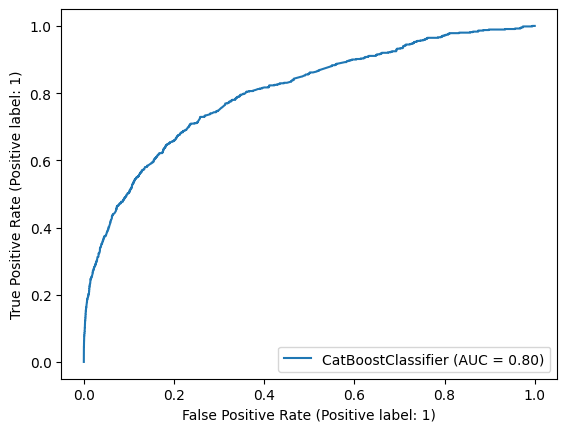

In [116]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt

print('AUC = %.2f' % roc_auc_score(y_train.to_numpy(), y_train_pred1['canc_prob']))  #1

metrics.plot_roc_curve(cb, x_test, y_test, ax=plt.gca())  #2
plt.show()